# Importing Liberaries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import matplotlib.pyplot as plt
from random import random
import numpy as np
import glob
from os import path, walk, listdir, makedirs
from os.path import exists
import shutil 

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

# Setup Pretrained Model

In [2]:
pretrained_model = VGG16(weights="imagenet")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
classes = pd.read_json(r"G:\Portfolio Tech Demo\Deep Learning\4 Learning From Pre Built Models\imagenet_class_index.json")
classes

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,n01440764,n01443537,n01484850,n01491361,n01494475,n01496331,n01498041,n01514668,n01514859,n01518878,...,n12768682,n12985857,n12998815,n13037406,n13040303,n13044778,n13052670,n13054560,n13133613,n15075141
1,tench,goldfish,great_white_shark,tiger_shark,hammerhead,electric_ray,stingray,cock,hen,ostrich,...,buckeye,coral_fungus,agaric,gyromitra,stinkhorn,earthstar,hen-of-the-woods,bolete,ear,toilet_tissue


In [5]:
classes = classes.T[[1]]
classes

,1
0,tench
1,goldfish
2,great_white_shark
3,tiger_shark
4,hammerhead
...,...
995,earthstar
996,hen-of-the-woods
997,bolete
998,ear


In [6]:
classes.to_dict()[1]

{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

# Testing Pretrained Model

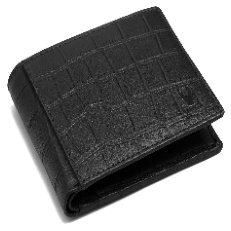

In [7]:
def load_img(path, target_size=None):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR format by default, convert to RGB
    if target_size:
        img = cv2.resize(img, target_size)
    return img

image_path = r"G:\Portfolio Tech Demo\Deep Learning\4 Learning From Pre Built Models\images\test image.jpg"
image_for_prediction = load_img(image_path, target_size=(224, 224))  # Adjust target_size as needed

# Display the image using matplotlib
plt.imshow(image_for_prediction)
plt.axis('off')
plt.show()

In [8]:
image_for_prediction  = np.array(image_for_prediction)
image_for_prediction = image_for_prediction.reshape(1,224,224,3)
image_for_prediction = preprocess_input(image_for_prediction)
pred = pretrained_model.predict(image_for_prediction)

In [9]:
classes["prob"] = np.round(pred.flatten(),4)*100
classes.sort_values("prob", ascending=False)

,1,prob
893,wallet,95.630005
748,purse,3.710000
626,lighter,0.100000
446,binder,0.070000
709,pencil_box,0.060000
...,...,...
336,marmot,0.000000
337,beaver,0.000000
338,guinea_pig,0.000000
339,sorrel,0.000000


# Tweeking Pretrained Model for Our Use

In [10]:
pretrained_model.layers

In [11]:
cat_dog_model = Sequential()

for layer in pretrained_model.layers[:-1]:
    layer.trainable = False # Don't train any of these layers from the pretrained model
    cat_dog_model.add(layer)

cat_dog_model.add(Dense(1,activation = "sigmoid"))

In [12]:
cat_dog_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [13]:
cat_dir = r"G:\Portfolio Tech Demo\Deep Learning\4 Learning From Pre Built Models\cats"
data_dir = path.dirname(cat_dir)
cat_dir = path.join(data_dir, "cats")
dog_dir = path.join(data_dir, "dogs")
target_size = (224, 224)

x = []  # Images
y = []  # Target labels

# Load and preprocess cat images
for input_img in glob.glob(path.join(cat_dir, "*.jpg")):
    img = load_img(input_img, target_size=target_size)
    img_array = img_to_array(img)
    # Random horizontal flip augmentation
    if random() > 0.9:  # 10% chance of flipping
        img_array = np.fliplr(img_array)  # Flip horizontally
    img_processed = preprocess_input(img_array)
    x.append(img_processed)
    y.append(0)  # 0=cats

# Load and preprocess dog images
for input_img in glob.glob(path.join(dog_dir, "*.jpg")):
    img = load_img(input_img, target_size=target_size)
    img_array = img_to_array(img)
    # Random horizontal flip augmentation
    if random() > 0.9:  # 10% chance of flipping
        img_array = np.fliplr(img_array)  # Flip horizontally
    img_processed = preprocess_input(img_array)
    x.append(img_processed)
    y.append(1)  # 1=dogs

In [14]:
x = np.array(x)
y = np.array(y)

x.shape

(2000, 224, 224, 3)

In [15]:
cat_dog_model.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy"])
cat_dog_model.fit(x=x, y=y, epochs=2, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1600 samples, validate on 400 samples
Epoch 1/2
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.0925 - acc: 0.9606 - val_loss: 0.0617 - val_acc: 0.9825
Epoch 2/2
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.0416 - acc: 0.9850 - val_loss: 0.0624 - val_acc: 0.9850


In [16]:
cat_dog_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [17]:
# Saving the model
cat_dog_model.save('cat_dog_model_vgg16.h5')

# Testing Tweeked Model

In [18]:
# Load the saved model
loaded_model = load_model(r"G:\Portfolio Tech Demo\Deep Learning\4 Learning From Pre Built Models\cat_dog_model_vgg16.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


[[0.99774253]]
Predicted Class Label: Dog


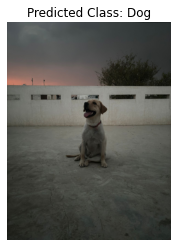

In [19]:
# Load the image
new_image_path = r"G:\Portfolio Tech Demo\Deep Learning\4 Learning From Pre Built Models\images\test image 2.jpeg"
image_for_prediction = load_img(new_image_path, target_size=(224, 224))

# Convert to NumPy array
image_for_prediction = np.array(image_for_prediction)
image_for_prediction = image_for_prediction.reshape(1, 224, 224, 3)

# Preprocess the image
image_for_prediction = preprocess_input(image_for_prediction)

# Get the prediction
preds = loaded_model.predict(image_for_prediction)
print(preds)

classes = ["Cat", "Dog"]
preds_class_index = 1 if preds[0][0] > 0.5 else 0
preds_class_label = classes[preds_class_index]
print(f"Predicted Class Label: {preds_class_label}")

# Display the image
img_display = cv2.imread(new_image_path)
img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
plt.imshow(img_display)
plt.title(f"Predicted Class: {preds_class_label}")
plt.axis('off')
plt.show()
